## TC 5033
### Word Embeddings

<br>

#### Activity 3b: Text Classification using RNNs and AG_NEWS dataset in PyTorch
<br>

- Objective:
    - Understand the basics of Recurrent Neural Networks (RNNs) and their application in text classification.
    - Learn how to handle a real-world text dataset, AG_NEWS, in PyTorch.
    - Gain hands-on experience in defining, training, and evaluating a text classification model in PyTorch.
    
<br>

- Instructions:
    - Data Preparation: Starter code will be provided that loads the AG_NEWS dataset and prepares it for training. Do not modify this part. However, you should be sure to understand it, and comment it, the use of markdown cells is suggested.

    - Model Setup: A skeleton code for the RNN model class will be provided. Complete this class and use it to instantiate your model.

    - Implementing Accuracy Function: Write a function that takes model predictions and ground truth labels as input and returns the model's accuracy.

    - Training Function: Implement a function that performs training on the given model using the AG_NEWS dataset. Your model should achieve an accuracy of at least 80% to get full marks for this part.

    - Text Sampling: Write a function that takes a sample text as input and classifies it using your trained model.

    - Confusion Matrix: Implement a function to display the confusion matrix for your model on the test data.

    - Submission: Submit your completed Jupyter Notebook. Make sure to include a markdown cell at the beginning of the notebook that lists the names of all team members. Teams should consist of 3 to 4 members.
    
<br>

- Evaluation Criteria:

    - Correct setup of all the required libraries and modules (10%)
    - Code Quality (30%): Your code should be well-organized, clearly commented, and easy to follow. Use also markdown cells for clarity. Comments should be given for all the provided code, this will help you understand its functionality.
    
   - Functionality (60%):
        - All the functions should execute without errors and provide the expected outputs.
        - RNN model class (20%)
        - Accuracy fucntion (10%)
        - Training function (10%)
        - Sampling function (10%)
        - Confucion matrix (10%)

        - The model should achieve at least an 80% accuracy on the AG_NEWS test set for full marks in this criterion.


Dataset

https://pytorch.org/text/stable/datasets.html#text-classification

https://paperswithcode.com/dataset/ag-news


#### Install libraries (if needed)

## Import libraries

In [1]:
# The following libraries are required for running the given code
# Please feel free to add any libraries you consider adecuate to complete the assingment.
import numpy as np
#PyTorch libraries
import torch
from torchtext.datasets import AG_NEWS
# Dataloader library
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
# Libraries to prepare the data
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset
# neural layers
from torch import nn
from torch.nn import functional as F

# These libraries are suggested to plot confusion matrix
# you may use others
import matplotlib.pyplot as plt
import scikitplot as skplt
import gc

/Users/alonsopedreromartinez/Documents/GitHub/pedreros_advanced_machine_learning/act_3b/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Get the train and the test datasets and dataloaders

Classes:

* 1 - World

* 2 - Sports

* 3 - Business

* 4 - Sci/Tech

We will convert them to:

* 0 - World

* 1 - Sports

* 2 - Business

* 3 - Sci/Tech

In [3]:
train_dataset, test_dataset = AG_NEWS()
train_dataset, test_dataset = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)

In [4]:
# Get the tokeniser
# tokeniser object
tokeniser = get_tokenizer('basic_english')

def yield_tokens(data):
    for _, text in data:
        yield tokeniser(text)

In [5]:
# Build the vocabulary
vocab = build_vocab_from_iterator(yield_tokens(train_dataset), specials=["<unk>"])
#set unknown token at position 0
vocab.set_default_index(vocab["<unk>"])

In [6]:
#test tokens
tokens = tokeniser('Welcome to TC5033')
print(tokens, vocab(tokens))

['welcome', 'to', 'tc5033'] [3314, 4, 0]


In [7]:
NUM_TRAIN = int(len(train_dataset)*0.9)
NUM_VAL = len(train_dataset) - NUM_TRAIN

In [8]:
train_dataset, val_dataset = random_split(train_dataset, [NUM_TRAIN, NUM_VAL])

In [9]:
print(len(train_dataset), len(val_dataset), len(test_dataset))

108000 12000 7600


In [10]:
labels =  ["World", "Sports", "Business", "Sci/Tech"]
max_tokens = 50
BATCH_SIZE = 256

In [11]:
def collate_batch(batch):
    y, x = list(zip(*batch))

    x = [vocab(tokeniser(text)) for text in x]
    x = [t + ([0]*(max_tokens - len(t))) if len(t) < max_tokens else t[:max_tokens] for t in x]

    return torch.tensor(x, dtype=torch.int32), torch.tensor(y, dtype=torch.int32) - 1

In [12]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)

### Let us build our RNN model

In [13]:
EMBEDDING_SIZE = 300
NEURONS = 128
LAYERS = 2
NUM_CLASSES = 4

In [14]:
class RecurrentModel(nn.Module):
    def __init__(self, embed_size, hidden, layers, num_classes):
        super().__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab),
                                            embedding_dim=embed_size)

        self.rnn = nn.GRU(input_size=embed_size,
                          hidden_size=hidden,
                          num_layers=layers,
                          batch_first=True,
                          dropout=0.5)
        
        self.fc = nn.Linear(hidden, num_classes)

    def forward(self, x):
        embedded = self.embedding_layer(x)

        rnn_out, _ = self.rnn(embedded)

        final_hidden_state = rnn_out[:, -1, :]

        out = self.fc(final_hidden_state)
        return out

In [15]:
def accuracy(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for text, labels in loader:
            text, labels = text.to(device), labels.to(device)
            outputs = model(text)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [16]:
def train(model, optimiser, epochs=100):
    model.train()
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        total_loss = 0
        for text, labels in train_loader:
            text, labels = text.to(device), labels.to(device)

            labels = labels.long()

            optimiser.zero_grad()

            outputs = model(text)
            loss = criterion(outputs, labels)

            loss.backward()
            optimiser.step()

            total_loss += loss.item()

        average_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs}, Avereage loss: {average_loss:.4f}")


In [17]:
epochs = 10
lr = 0.001

rnn_model = RecurrentModel(EMBEDDING_SIZE, NEURONS, LAYERS, NUM_CLASSES)
optimiser = torch.optim.Adam(rnn_model.parameters(), lr=lr)

In [18]:
train(rnn_model, optimiser=optimiser,  epochs=epochs)

Epoch 1/10, Avereage loss: 0.5923
Epoch 2/10, Avereage loss: 0.2407
Epoch 3/10, Avereage loss: 0.1686
Epoch 4/10, Avereage loss: 0.1186
Epoch 5/10, Avereage loss: 0.0827
Epoch 6/10, Avereage loss: 0.0588
Epoch 7/10, Avereage loss: 0.0433
Epoch 8/10, Avereage loss: 0.0335
Epoch 9/10, Avereage loss: 0.0280
Epoch 10/10, Avereage loss: 0.0228


In [19]:
print(f'{accuracy(rnn_model, test_loader):.4f}')

0.9061


In [20]:
NUM_SAMPLES = 5

In [21]:
def sample_text(model, loader):
    model.eval()
    samples = []
    
    with torch.no_grad():
        for text, labels in loader:
            text, labels = text.to(device), labels.to(device)
            outputs = model(text)
            _, predicted = torch.max(outputs, 1)
            
            for i in range(NUM_SAMPLES):
                sample_text = " ".join([vocab.get_itos()[idx] for idx in text[i].tolist() if idx != 0])
                samples.append((sample_text, labels[i].item(), predicted[i].item()))
            
            break
    
    print("\nPredictions:")
    for text, actual, pred in samples:
        print(f"Text: {text}\nActual: {labels[actual]}\nPredicted: {labels[pred]}\n\n")


In [22]:
sample_text(rnn_model, test_loader)


Predictions:
Text: republican convention dogged by relentless protests ( reuters ) reuters - five thousand people protesting losses formed a 3 mile unemployment line in manhattan on\wednesday and aids activists disrupted a republican meeting on\the third day of the party ' s convention to nominate to a second term in
Actual: 0
Predicted: 0


Text: sandia motor speedway for sale on ebay ( ap ) ap - and the race is off ! only 29 days and some odd hours left to place your bid on ebay to buy the sandia motor speedway .
Actual: 0
Predicted: 0


Text: toy store profits r back up toy retailer toys r us has posted a second-quarter profit , turning the loss it made over the same period the year before . the new jersey-based group , which is considering quitting the toys business , turned
Actual: 2
Predicted: 2


Text: asean moves closer to single market with #39 road map #39 , global trade &lt b&gt . . . &lt /b&gt jakarta asean finance ministers ended a meeting which saw southeast asia edge cl

In [23]:
# create confusion matrix
def plot_confusion_matrix(model_input, test_loader_input):
    """
    Plots a confusion matrix for the given model and test data loader.
    """
    model_input.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for text, labels in test_loader_input:
            text, labels = text.to(device), labels.to(device)
            outputs = model_input(text)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    skplt.metrics.plot_confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3], 
                                        normalize=True, title="Normalized Confusion Matrix",
                                        figsize=(8, 6))
    plt.show()
    gc.collect()   

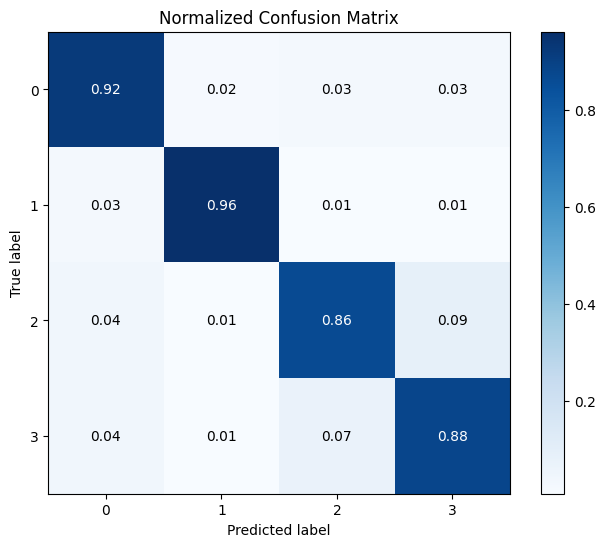

In [24]:
plot_confusion_matrix(rnn_model, test_loader)